In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import product
from tqdm import tqdm

# Qiskit Imports
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [4]:
# Define Graph Utilities
def draw_side_by_side(G1, G2, title1="Graph 1", title2="Graph 2", main_title=""):
    """Helper to draw two graphs side by side."""
    plt.figure(figsize=(10, 4))
    plt.suptitle(main_title, fontsize=16)
    
    plt.subplot(1, 2, 1)
    pos1 = nx.spring_layout(G1, seed=42)
    nx.draw(G1, pos1, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
    plt.title(title1)
    
    plt.subplot(1, 2, 2)
    pos2 = nx.spring_layout(G2, seed=42)
    nx.draw(G2, pos2, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=500)
    plt.title(title2)
    plt.show()

In [5]:
def get_gi_qubo(G1, G2, penalty_weight=10.0):
    """
    Constructs the Quadratic Program for Graph Isomorphism.
    Variables x_{u,v} = 1 if node u in G1 maps to node v in G2.
    Constraints:
    1. Bijection: One-to-one mapping (Row sums = 1, Col sums = 1).
    2. Edge Consistency: Adjacency matrices must match under permutation.
    """
    n = len(G1.nodes)
    if len(G2.nodes) != n:
        raise ValueError("Graphs must have the same number of nodes")

    qp = QuadraticProgram()
    
    # 1. Create Binary Variables x_{i,j} for mapping node i of G1 to node j of G2
    vars_map = {}
    for u in range(n):
        for v in range(n):
            var_name = f"x_{u}_{v}"
            qp.binary_var(var_name)
            vars_map[(u, v)] = var_name

    # 2. Add Linear constraints for Bijection (One-hot rows and columns)
    # Each node in G1 maps to exactly one node in G2
    for u in range(n):
        qp.linear_constraint(
            linear={vars_map[(u, v)]: 1 for v in range(n)},
            sense="==",
            rhs=1,
            name=f"row_{u}"
        )

    # Each node in G2 is mapped to by exactly one node in G1
    for v in range(n):
        qp.linear_constraint(
            linear={vars_map[(u, v)]: 1 for u in range(n)},
            sense="==",
            rhs=1,
            name=f"col_{v}"
        )

    # 3. Add Quadratic Objective for Edge Inconsistency
    # Minimize: sum (x_{u,v} * x_{u',v'}) for all mappings that violate adjacency
    # Violation: (u, u') is edge in G1 but (v, v') is NOT in G2 (or vice versa)
    
    quad_dict = {}
    
    # Iterate over all pairs of edges potential mappings
    # For every pair of nodes (u, u') in G1 and (v, v') in G2
    for u, up in product(range(n), repeat=2):
        if u == up: continue # Skip self loops for simplicity unless graphs have them
        
        for v, vp in product(range(n), repeat=2):
            if v == vp: continue

            # Check Adjacency
            g1_edge = G1.has_edge(u, up)
            g2_edge = G2.has_edge(v, vp)

            # If structural mismatch found between these pairs
            if g1_edge != g2_edge:
                # We penalize selecting BOTH x_{u,v} and x_{up, vp}
                # Cost += x_{u,v} * x_{up, vp}
                
                key = (vars_map[(u, v)], vars_map[(up, vp)])
                # Sort key to ensure uniqueness in dictionary
                if key[0] > key[1]: key = (key[1], key[0])
                
                quad_dict[key] = quad_dict.get(key, 0) + penalty_weight

    qp.minimize(quadratic=quad_dict)
    return qp

In [7]:
def solve_gi(G1, G2):
    """Solves GI problem using QAOA and returns result + energy."""
    print(f"Building QUBO for {len(G1)} nodes ({len(G1)**2} qubits)...")
    qp = get_gi_qubo(G1, G2)
    
    # Setup QAOA with the new StatevectorSampler
    sampler = StatevectorSampler(seed=42) # Seed is optional but good for reproducibility
    optimizer = COBYLA(maxiter=100)
    
    # Instantiate QAOA
    qaoa = QAOA(sampler, optimizer, reps=1)
    
    # Minimum Eigen Optimizer wraps QAOA
    solver = MinimumEigenOptimizer(qaoa)
    
    print("Running Quantum Solver...")
    result = solver.solve(qp)
    return result


--- TEST CASE 1: ISOMORPHIC GRAPHS ---


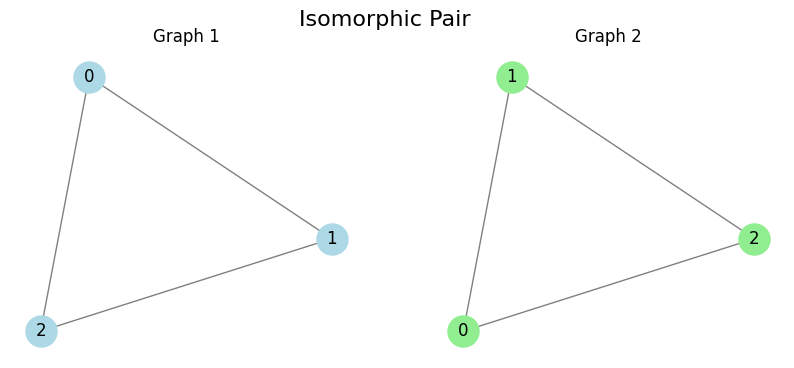

Building QUBO for 3 nodes (9 qubits)...
Running Quantum Solver...


/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Isomorphic Result Status: OptimizationResultStatus.SUCCESS
Optimal Value (Energy): 0.0
Mapping Found (x variables): 
[1. 0. 0. 0. 1. 0. 0. 0. 1.]

--- TEST CASE 2: NON-ISOMORPHIC GRAPHS ---


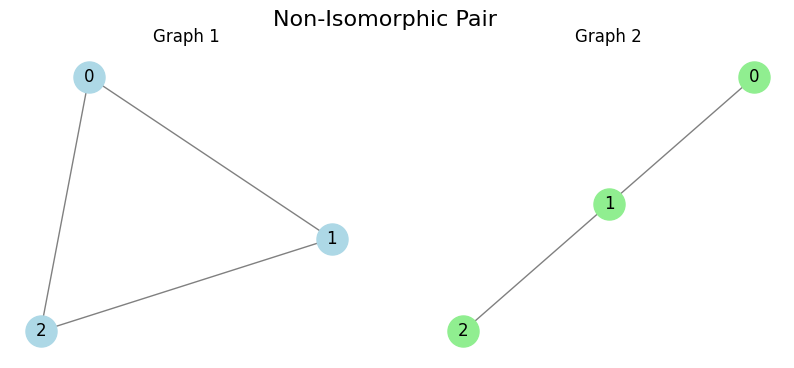

Building QUBO for 3 nodes (9 qubits)...
Running Quantum Solver...


/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Non-Isomorphic Result Status: OptimizationResultStatus.SUCCESS
Optimal Value (Energy): 20.0


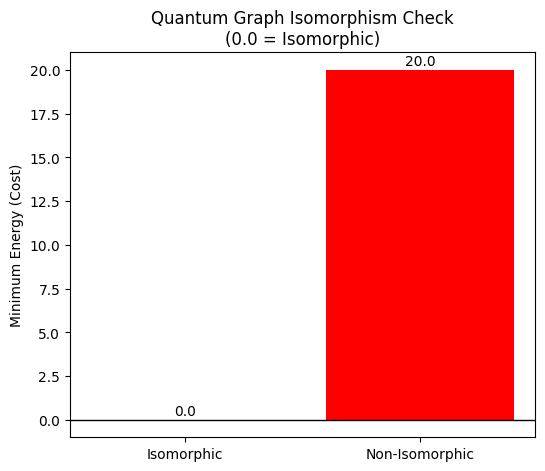


Summary:
>> Pair 1 is ISOMORPHIC (Energy ~ 0)
>> Pair 2 is NON-ISOMORPHIC (Energy > 0)


In [8]:
# ==========================================
# MAIN EXECUTION
# ==========================================

if __name__ == "__main__":
    # --- Case 1: Isomorphic Graphs (Triangle vs Permuted Triangle) ---
    # Graph 1: 0-1-2-0 (Triangle)
    G_iso_1 = nx.Graph([(0, 1), (1, 2), (2, 0)])
    
    # Graph 2: Same structure, different labels/order
    G_iso_2 = nx.Graph([(0, 2), (2, 1), (1, 0)]) 
    # Actually, let's make it clearer by re-labelling for visual difference
    mapping = {0: 1, 1: 2, 2: 0} # Permutation
    G_iso_2 = nx.relabel_nodes(G_iso_1, mapping)

    print("\n--- TEST CASE 1: ISOMORPHIC GRAPHS ---")
    draw_side_by_side(G_iso_1, G_iso_2, main_title="Isomorphic Pair")
    result_iso = solve_gi(G_iso_1, G_iso_2)
    
    print(f"Isomorphic Result Status: {result_iso.status}")
    print(f"Optimal Value (Energy): {result_iso.fval}")
    print(f"Mapping Found (x variables): \n{result_iso.x}")

    # --- Case 2: Non-Isomorphic Graphs (Triangle vs Line) ---
    G_non_1 = nx.Graph([(0, 1), (1, 2), (2, 0)]) # Triangle
    G_non_2 = nx.Graph([(0, 1), (1, 2)])         # Line (Missing closing edge)

    print("\n--- TEST CASE 2: NON-ISOMORPHIC GRAPHS ---")
    draw_side_by_side(G_non_1, G_non_2, main_title="Non-Isomorphic Pair")
    result_non = solve_gi(G_non_1, G_non_2)

    print(f"Non-Isomorphic Result Status: {result_non.status}")
    print(f"Optimal Value (Energy): {result_non.fval}")
    
    # --- Comparison Plot ---
    labels = ['Isomorphic', 'Non-Isomorphic']
    energies = [result_iso.fval, result_non.fval]

    plt.figure(figsize=(6, 5))
    bars = plt.bar(labels, energies, color=['green', 'red'])
    plt.ylabel('Minimum Energy (Cost)')
    plt.title('Quantum Graph Isomorphism Check\n(0.0 = Isomorphic)')
    plt.axhline(0, color='black', linewidth=1)
    
    # Add text labels
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')
        
    plt.ylim(bottom=-1) # Give some space
    plt.show()

    print("\nSummary:")
    if result_iso.fval < 1e-5:
        print(">> Pair 1 is ISOMORPHIC (Energy ~ 0)")
    else:
        print(">> Pair 1 is NOT isomorphic")
        
    if result_non.fval > 1e-5:
        print(">> Pair 2 is NON-ISOMORPHIC (Energy > 0)")
    else:
        print(">> Pair 2 is ISOMORPHIC")

In [12]:
class GraphIsoAnalyzer:
    def __init__(self):
        self.sampler = StatevectorSampler(seed=42)
        
    def build_qubo(self, G1, G2, penalty_weight=20.0):
        """Builds the strict GI QUBO."""
        n = len(G1.nodes)
        qp = QuadraticProgram()
        
        # Variables x_{u,v}
        vars_map = {}
        for u in range(n):
            for v in range(n):
                name = f"x_{u}_{v}"
                qp.binary_var(name)
                vars_map[(u, v)] = name

        # Constraints: Row/Col sums = 1
        for i in range(n):
            qp.linear_constraint(linear={vars_map[(i, v)]: 1 for v in range(n)}, sense="==", rhs=1, name=f"row_{i}")
            qp.linear_constraint(linear={vars_map[(u, i)]: 1 for u in range(n)}, sense="==", rhs=1, name=f"col_{i}")

        # Objective: Edge mismatch penalty
        quad_dict = {}
        for u, up in product(range(n), repeat=2):
            if u == up: continue
            for v, vp in product(range(n), repeat=2):
                if v == vp: continue
                
                # If edge structure disagrees
                if G1.has_edge(u, up) != G2.has_edge(v, vp):
                    # Penalty for mapping u->v AND up->vp
                    key = (vars_map[(u, v)], vars_map[(up, vp)])
                    if key[0] > key[1]: key = (key[1], key[0])
                    quad_dict[key] = quad_dict.get(key, 0) + penalty_weight

        qp.minimize(quadratic=quad_dict)
        return qp, vars_map

    def solve_single_run(self, qp, reps=1, maxiter=100):
        """Runs QAOA once and captures the convergence trace."""
        history = []
        
        # --- FIX IS HERE ---
        # We attach the callback to QAOA, not COBYLA.
        def callback(eval_count, params, mean, meta):
            history.append(mean)

        optimizer = COBYLA(maxiter=maxiter) 
        qaoa = QAOA(self.sampler, optimizer, reps=reps, callback=callback)
        # -------------------
        
        solver = MinimumEigenOptimizer(qaoa)
        result = solver.solve(qp)
        
        return result, history

    def analyze_pair(self, G1, G2, name="Pair", runs=5):
        print(f"\n{'='*60}")
        print(f"ANALYZING: {name} | Nodes: {len(G1)} | Qubits: {len(G1)**2}")
        print(f"{'='*60}")
        
        qp, vars_map = self.build_qubo(G1, G2)
        n = len(G1)
        
        best_result = None
        best_energy = float('inf')
        all_histories = []
        success_count = 0
        
        with tqdm(total=runs, desc="Quantum Optimization Runs") as pbar:
            for i in range(runs):
                result, hist = self.solve_single_run(qp)
                all_histories.append(hist)
                
                if result.fval < 1e-4:
                    success_count += 1
                
                if result.fval < best_energy:
                    best_energy = result.fval
                    best_result = result
                
                pbar.update(1)

        # --- Visualizations ---
        fig = plt.figure(figsize=(18, 10))
        gs = fig.add_gridspec(2, 3)

        # 1. Graph Structures
        ax1 = fig.add_subplot(gs[0, 0])
        pos1 = nx.spring_layout(G1, seed=1)
        nx.draw(G1, pos1, ax=ax1, with_labels=True, node_color='skyblue', edge_color='k')
        ax1.set_title("Graph 1")

        ax2 = fig.add_subplot(gs[0, 1])
        pos2 = nx.spring_layout(G2, seed=1)
        nx.draw(G2, pos2, ax=ax2, with_labels=True, node_color='lightgreen', edge_color='k')
        ax2.set_title("Graph 2")

        # 2. Convergence Plot
        ax3 = fig.add_subplot(gs[0, 2])
        for h in all_histories:
            ax3.plot(h, alpha=0.3, color='blue')
        
        # Handle cases where histories might be different lengths
        if all_histories:
            min_len = min(len(h) for h in all_histories)
            if min_len > 0:
                avg_hist = np.mean([h[:min_len] for h in all_histories], axis=0)
                ax3.plot(avg_hist, color='red', linewidth=2, label='Avg Trace')
        
        ax3.set_title("Optimizer Convergence")
        ax3.set_xlabel("Iterations")
        ax3.set_ylabel("Energy (Cost)")
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # 3. Result Heatmap
        ax4 = fig.add_subplot(gs[1, 0])
        perm_matrix = np.zeros((n, n))
        
        # Map variables back to matrix
        # Note: qp.variables usually stores them in order of creation if we iterate
        # But let's be safe and use the dictionary
        val_map = {var.name: val for var, val in zip(qp.variables, best_result.x)}
        
        for r in range(n):
            for c in range(n):
                perm_matrix[r, c] = val_map[f"x_{r}_{c}"]

        sns.heatmap(perm_matrix, annot=True, cmap="Blues", cbar=False, ax=ax4, linewidths=1, linecolor='black')
        ax4.set_title(f"Best Solution Matrix\nEnergy: {best_energy:.4f}")
        ax4.set_xlabel("Graph 2 Nodes")
        ax4.set_ylabel("Graph 1 Nodes")

        # 4. Stats
        ax5 = fig.add_subplot(gs[1, 1:])
        ax5.axis('off')
        
        status_text = "ISOMORPHIC" if best_energy < 1e-4 else "NON-ISOMORPHIC"
        color_text = "green" if best_energy < 1e-4 else "red"
        
        stats = [
            f"Analysis Result: {status_text}",
            f"Best Energy Found: {best_energy:.5f} (0.0 is ideal)",
            f"Success Rate: {success_count}/{runs} runs found min energy",
            f"Optimizer: COBYLA (100 iters)",
            f"Ansatz: QAOA (1 rep)"
        ]
        
        ax5.text(0.1, 0.8, "\n\n".join(stats), fontsize=14, family='monospace', 
                 bbox=dict(facecolor='white', edgecolor=color_text, boxstyle='round,pad=1'))

        plt.tight_layout()
        plt.show()


ANALYZING: Isomorphic Triangle | Nodes: 3 | Qubits: 9


Quantum Optimization Runs:   0%|          | 0/5 [00:00<?, ?it/s]/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
Quantum Optimization Runs:  20%|██        | 1/5 [00:21<01:25, 21.34s/it]/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu

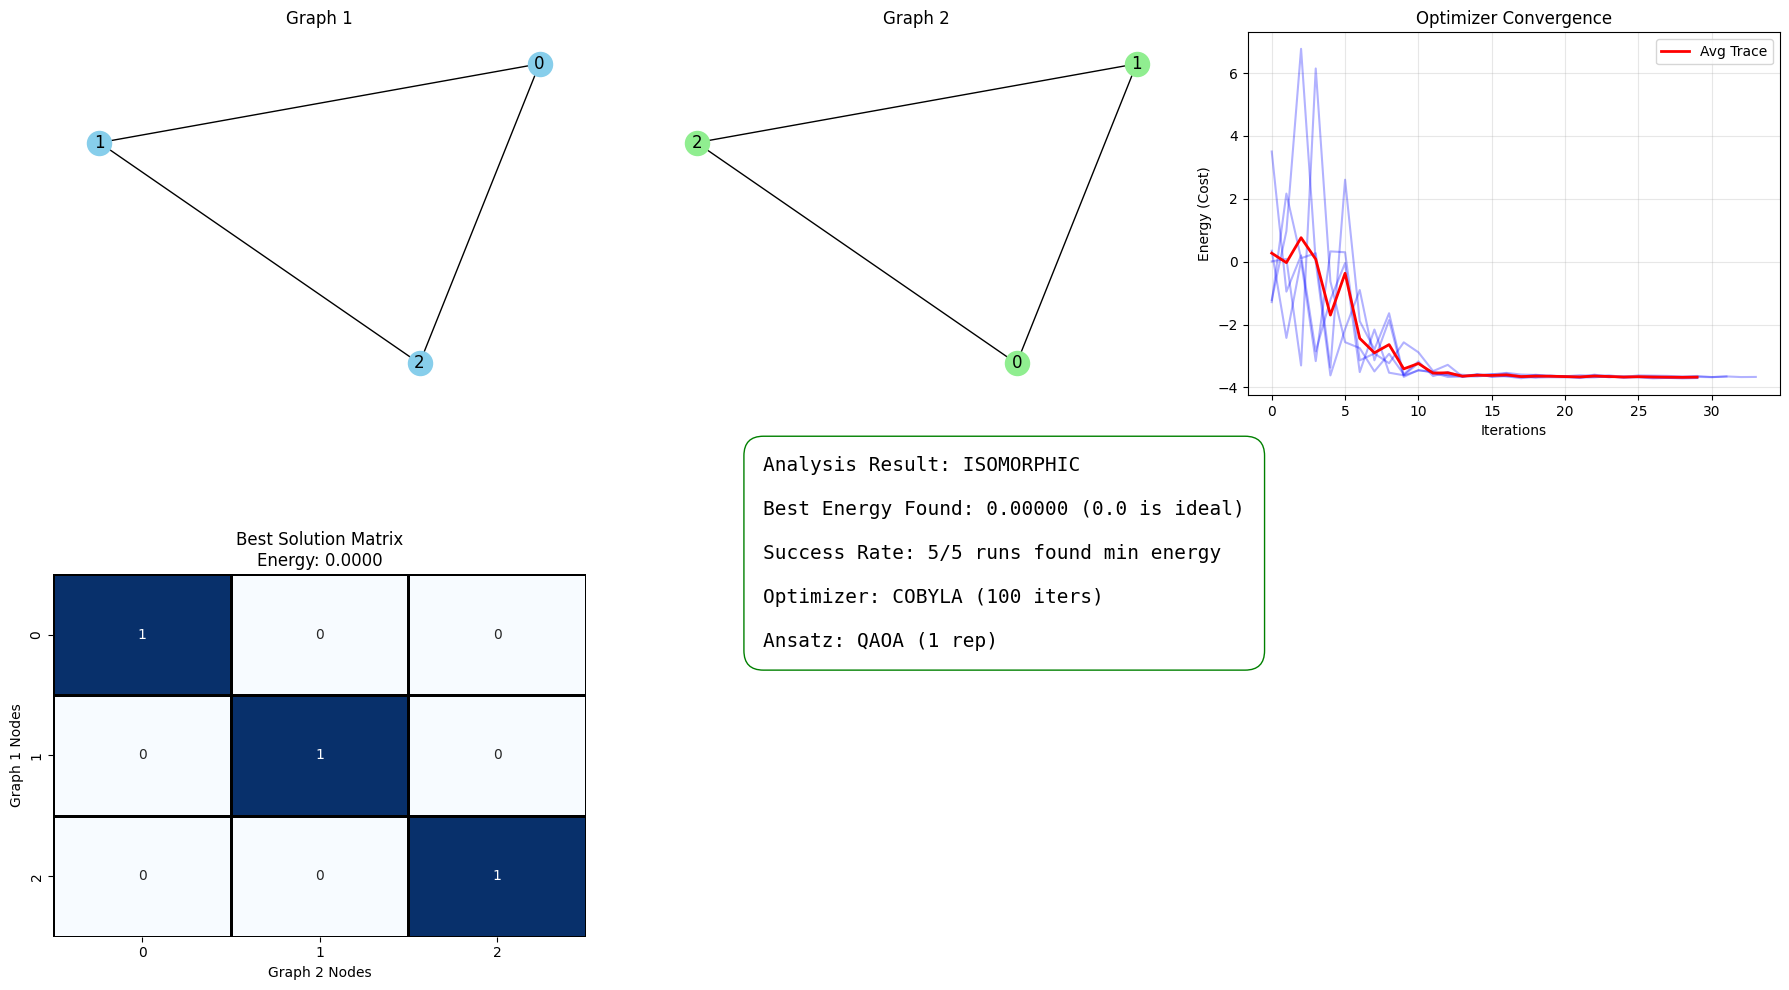


ANALYZING: Triangle vs Line | Nodes: 3 | Qubits: 9


Quantum Optimization Runs:   0%|          | 0/5 [00:00<?, ?it/s]/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
Quantum Optimization Runs:  20%|██        | 1/5 [00:29<01:59, 30.00s/it]/Users/tchatterjee/anaconda3/envs/qdc/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu

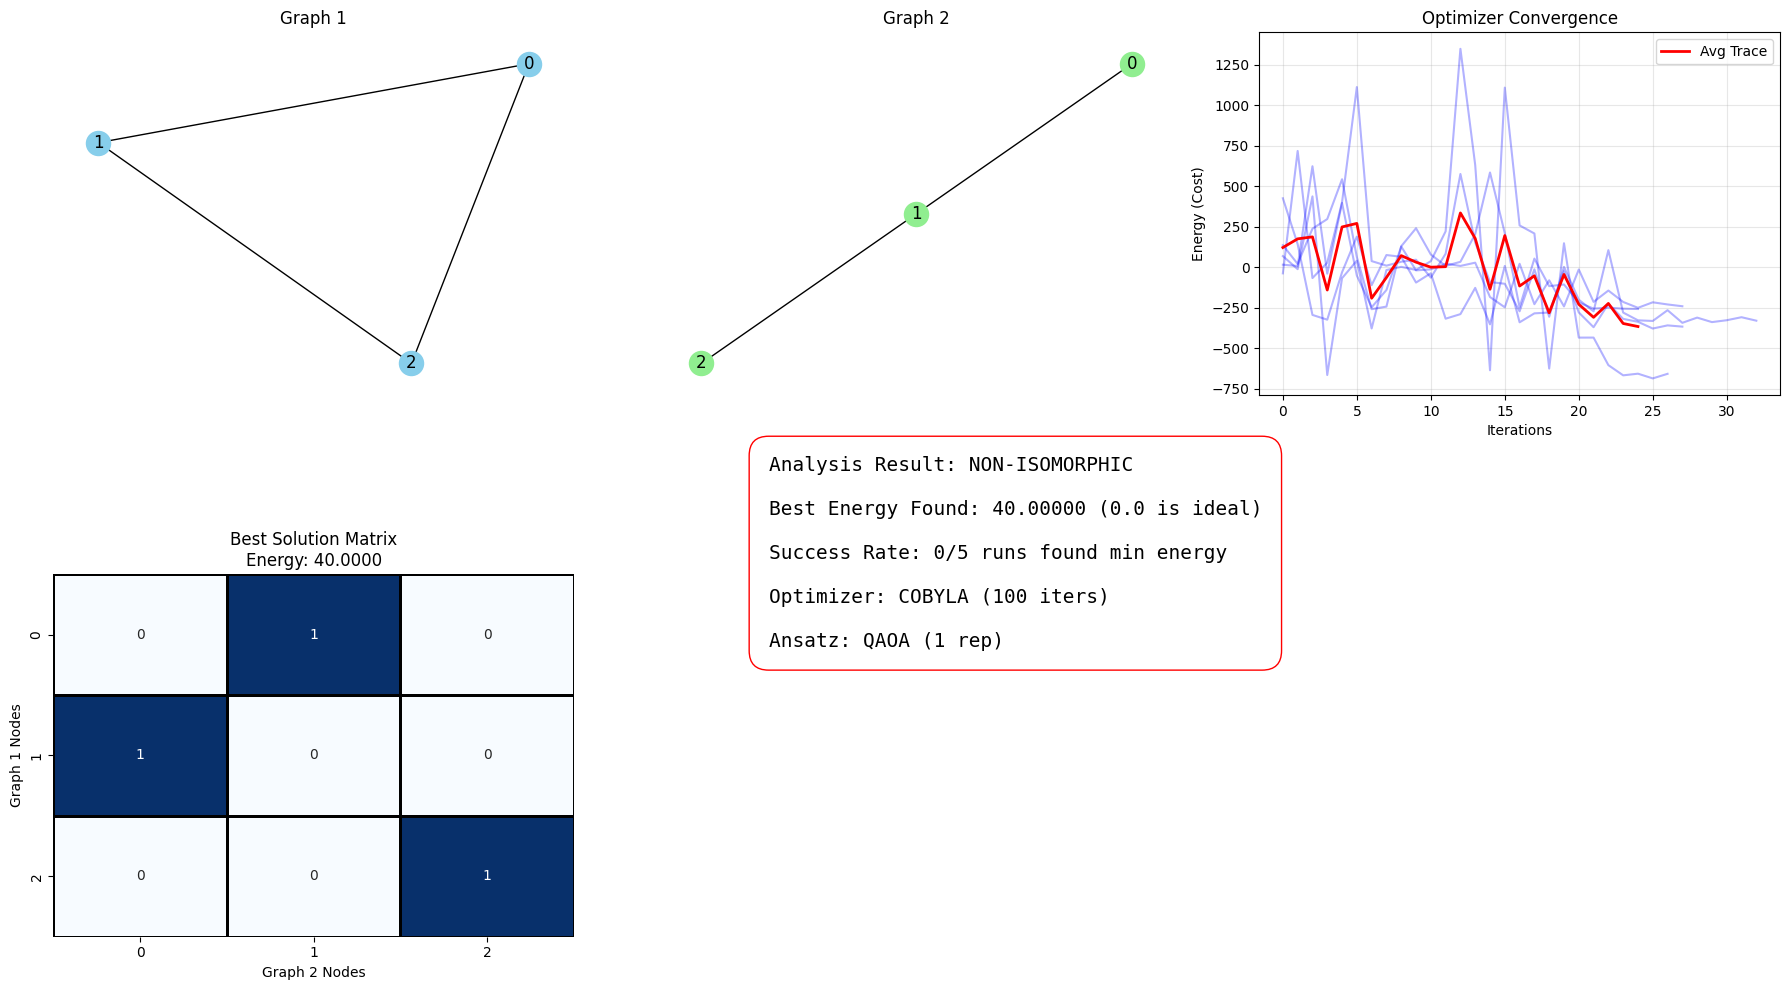

In [13]:
# ==========================================
# DATA GENERATION & EXECUTION
# ==========================================

analyzer = GraphIsoAnalyzer()

# --- CASE 1: ISOMORPHIC ---
G_iso_1 = nx.Graph([(0, 1), (1, 2), (2, 0)])
G_iso_2 = nx.Graph([(1, 2), (2, 0), (0, 1)]) 
analyzer.analyze_pair(G_iso_1, G_iso_2, name="Isomorphic Triangle", runs=5)

# --- CASE 2: NON-ISOMORPHIC ---
G_non_1 = nx.Graph([(0, 1), (1, 2), (2, 0)]) 
G_non_2 = nx.Graph([(0, 1), (1, 2)])
analyzer.analyze_pair(G_non_1, G_non_2, name="Triangle vs Line", runs=5)